## Package
匯入所有所需套件

In [1]:
import gym

In [2]:
from collections import deque

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from IPython import display

In [4]:
import torch
from torch.nn import functional as F
import torch.nn as nn

In [5]:
import numpy as np

In [6]:
from skimage import transform
from skimage.color import rgb2gray

In [7]:
import os
import time

In [8]:
from copy import deepcopy

## Useful function
用來呈現遊玩畫面<br>如果是用伺服器跑，env.render無法正常執行，利用 matplotlib渲染圖片在jupyter中，並用ipython的display.clear_output將舊的圖片刪掉，形成動圖

In [9]:
def show_state(obs, step=0, info=""):
    """
    show real time observation/state
    """
    plt.figure(3)
    plt.clf()
    plt.imshow(obs)
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

## DQN + CNN
DQN架構如下
![title](static/DQN.png)
進入DQN前用CNN將高維度的圖片降維

In [10]:
class DQN(nn.Module):
    """
    DQN model with CNN layer processing image state
    """
    def __init__(self, action_dim, in_channel=1):
        super(DQN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channel, 32, 8, 4)
        self.conv_2 = nn.Conv2d(32, 64, 4, 2)
        self.conv_3 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, action_dim)
        
    def forward(self, state):
        x = F.relu(self.conv_1(state))
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

## Experience Replay
**Using numpy reduce memory consumption and improve speed performance**<br>
將玩過的經驗存入 replay buffer，訓練時從其中隨機挑取，以打破資料時間上的correlation<br>
實作上用numpy array取代list以減少memory負擔和加速執行速度

In [11]:
class ReplayBuffer(object):
    """
    Buffer to store Experience Replay
    """
    def __init__(self, max_size=75000):
        self.state_mem = np.zeros((max_size,4,84,84))
        self.next_state_mem = np.zeros((max_size,4,84,84))
        self.action_mem = np.zeros((max_size,))
        self.reward_mem = np.zeros((max_size,))
        self.done_mem = np.zeros((max_size,))
        self.max_size = max_size
        self.ptr = 0
        self.current_size = 0
    def __len__(self):
        return self.current_size
    def add(self,transition):
        state, next_state, action, reward, done = transition
        self.state_mem[self.ptr] = state
        self.next_state_mem[self.ptr] = next_state
        self.action_mem[self.ptr] = action
        self.reward_mem[self.ptr] = reward
        self.done_mem[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.current_size = self.current_size + 1 if self.current_size < self.max_size else self.max_size
    
    def sample(self, batch_size):
        ind = np.random.randint(0, self.current_size, size=batch_size)
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = self.state_mem[ind], self.next_state_mem[ind], self.action_mem[ind], self.reward_mem[ind], self.done_mem[ind]

        return batch_states, batch_next_states, batch_actions.reshape(-1, 1), batch_rewards.reshape(-1, 1), batch_dones.reshape(-1, 1)

## Preprocessing
參考paper，將圖片從(210,160,3) 轉成(84,84)，並對值進行正規化<br>
實作方法參考https://skywalker0803r.medium.com/%E8%A8%93%E7%B7%B4dqn%E7%8E%A9atari-space-invaders-9bc0fc264f5b

In [12]:
def preprocess(state):
    """
    preprocess state from rgb image (210,160,3) to gray image (84,84) with normalization 
    """
    gray = rgb2gray(state)
    cropped_image = gray[8:-12, 4:-12]
    normalized_image = cropped_image / 255.0
    processed_image = transform.resize(normalized_image, [84,84])
    return processed_image

## Agent
agent功能:
- 做動作
- 訓練

In [13]:
class Agent(object):
    """
    RL agent contain one DQN network and one DQN target network
    """
    def __init__(self, action_dim, in_channel, lr, device):
        self.DQN_model = DQN(action_dim, in_channel).to(device)
        self.DQN_target = DQN(action_dim, in_channel).to(device)
        self.DQN_target.load_state_dict(self.DQN_model.state_dict())
        self.loss_func = nn.MSELoss()
        self.optimizer = torch.optim.Adam(params=self.DQN_model.parameters(),lr=lr)
        self.device = device
        self.learning_counter = 0
        self.debug = []
        
    def select_action(self, state):
        """
        select action while playing
        use epsilon-greedy algo. (outside)
        """
        # state -> np.array(4 ,84, 84), x -> Tensor(1, 4, 84, 84)
        x = torch.Tensor(state).unsqueeze(0).to(self.device)
        
        
        
        # Q_value -> tensor(1, action_dim)
        Q_value = self.DQN_model(x)
        
        # action -> int
        action = torch.max(Q_value, 1)[1].data.cpu().numpy()[0]
        
        # Q_value -> float
        #Q_max = torch.max(Q_value, 1)[0].data.cpu().numpy()[0]
        
        return action, Q_value.cpu().detach().numpy()
    
    def train(self, replaybuffer, batch_size=100, discount=0.99, policy_freq=2):
        """
        training a batch
        replaybuffer -> object: containing experience
        iteration -> int: current iteration
        batch_size -> int: batch size, default 100
        discount -> float: discount factor - gamma, default 0.99
        policy_freq -> int: every policy_freq iterations update target network once, default 2
        """
        # sample batch from experience replay
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replaybuffer.sample(batch_size)
        
        # batch_states -> np.array(batch, 4, 84, 84), states -> Tensor(batch, 4, 84, 84)
        states = torch.Tensor(batch_states).to(self.device)
        
        # batch_next_states -> np.array(batch, 4, 84, 84), next_states -> Tensor(batch, 4, 84, 84)
        next_states = torch.Tensor(batch_next_states).to(self.device)
        
        # batch_actions -> np.array(batch, 1), actions -> LongTensor(batch, 1), index must be int64
        actions = torch.LongTensor(batch_actions).to(self.device)
        
        # batch_rewards -> np.array(batch, 1), rewards -> Tensor(batch, 1)
        rewards = torch.Tensor(batch_rewards).to(self.device)
        
        # batch_dones -> np.array(batch, 1), dones -> Tensor(batch, 1)
        dones = torch.Tensor(batch_dones).to(self.device)
        
        # next_states -> Tensor(batch, 4, 84, 84), Q_next -> Tensor(batch, action_dim)
        # detach target to prevent gradient descent on target network
        Q_next = self.DQN_target(next_states).detach()
        
        # self.DQN_model(states) -> Tensor(batch, action_dim), Q_now -> Tensor(batch, 1)
        Q_now = self.DQN_model(states).gather(-1, actions)
        
        # Q(st, at) = rt + gamma * max_a': Q'(st+1, a') rewards 要加 s，幹 = =
        Q_target = rewards +  discount * Q_next.max(-1)[0].unsqueeze(-1) #(1 - dones) *
        loss = self.loss_func(Q_now, Q_target)
#         self.debug.append(loss.item())
#         a = list(self.DQN_model.parameters())[0].clone()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
#         b = list(self.DQN_model.parameters())[0].clone()
#        self.debug.append(torch.equal(a.data, b.data))
        
        self.learning_counter += 1
        if self.learning_counter % policy_freq == 0:
            # update target network
            self.DQN_target.load_state_dict(self.DQN_model.state_dict())
        
        return loss.item()
        
    def save(self, filename, directory):
        torch.save(self.DQN_model.state_dict(), '%s/%s_DQN_CNN.pth' % (directory, filename))
  
    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.DQN_model.load_state_dict(torch.load('%s/%s_DQN_CNN.pth' % (directory, filename)))
        self.DQN_target.load_state_dict(self.DQN_model.state_dict())

## Hyperparameters
超參數

In [14]:
env_name = 'SpaceInvaders-v0'
seed = 0
eval_freq = 5 # 5e3
lr = 0.0002
max_episode = 100 # 5e5
max_timestep = 1e6
isuseepisode = False
save_models = True
batch_size = 32
discount = 0.99
policy_freq = 1e5
memory_capacity = 5e4 # 2e3
epsilon_start = 1.0
epsilon_end = 0.1
decay_rate = 0.00001
perform_clip = True

## Env setup
設定環境參數

In [15]:
filename = "%s_%s_%s" % ("DQN", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (filename))
print ("---------------------------------------")

---------------------------------------
Settings: DQN_SpaceInvaders-v0_0
---------------------------------------


In [16]:
if not os.path.exists(f"./{filename}_results"):
    os.makedirs(f"./{filename}_results")
if save_models and not os.path.exists(f"./{filename}_pytorch_models"):
    os.makedirs(f"./{filename}_pytorch_models")

In [17]:
env = gym.make(env_name)

In [18]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
action_dim = env.action_space.n

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
agent = Agent(action_dim, 4, lr, device)

In [21]:
replaybuffer = ReplayBuffer()

## Evaluation
驗證環節

In [22]:
def evaluate(agent, eval_episodes=10):
    avg_reward = 0.
    avg_Q_value = 0
    for _ in range(eval_episodes):
        obs = env.reset()
        state = deque([np.zeros((84, 84)) for i in range(4)],maxlen=4)
        state.append(preprocess(obs))
        for _ in range(3):
            obs, _, _, _ = env.step(0)
            state.append(preprocess(obs))
        done = False
        t = 0
        while not done:
            t += 1
            action, Q_predict = agent.select_action(np.array(state))
            avg_Q_value += Q_predict.mean()
            for _ in range(4):
                obs, reward, done, _ = env.step(action)
                state.append(preprocess(obs))
                if done: break
            avg_reward += reward
        avg_Q_value /= t
    avg_reward /= eval_episodes
    avg_Q_value /= eval_episodes
    print ("---------------------------------------")
    print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
    print ("---------------------------------------")
    return avg_reward, avg_Q_value

## Initializing variables
初始化變數

In [23]:
current_episode = 0
current_timestep = 0
total_loss = []
reward_record = []
eval_reward_record = []
eval_Q_value_record = []
training_epsilon = epsilon_start

## Train

## Frame skipping
訓練過程加入 frame skipping技術

In [24]:
t0 = time.time()
decay_step = 0
state = None
stacked_frame = None
# 練 max_episode 個 episodes
while True:
    
     # 練 max_episode 個 episodes
    if isuseepisode and current_episode > max_episode:
        break
    # 練 max_timestep 個 timestep
    if not isuseepisode and current_timestep > max_timestep:
        break
        
    # 初始每次 episode 的參數
    t = 0
    rewards = 0
    episode_loss = 0.0
    loss_step = 0
    frame = env.reset()
    del stacked_frame
    stacked_frame = deque([np.zeros((84, 84)) for i in range(4)],maxlen=4)
    
    # 前4張 action 都做 NOP
    stacked_frame.append(preprocess(frame))
    for _ in range(3):
        frame, _, _, _ = env.step(0)
        stacked_frame.append(preprocess(frame))
    # 初始化 state
    del state
    state = np.array(stacked_frame)
    
    # 進入 episode
    while True:
        # episode 中的 timestep 更新
        t += 1
        
        # epsilon
        training_epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-decay_rate * decay_step)
        # epsilon-greedy
        if np.random.uniform() < training_epsilon: 
            action = np.random.randint(0, action_dim)# 隨機
        else:
            # stacked_frame -> deque(t1, t2, t3, t4)
            action, _ = agent.select_action(state)# agent 挑
            
        # play with env frame skipping(一次刷新4次frames)
        for _ in range(4):
            next_frame, reward, done, _ = env.step(action)
            stacked_frame.append(preprocess(next_frame))
            if done: break
        
        next_state = np.array(stacked_frame)
        
        # reward 限制在 [-1,1]
        reward = np.clip(reward,-1,1) if perform_clip else reward

        # 存進 experience replay buffer
        replaybuffer.add((state, next_state, action, reward, done))
        
        # 累積 reward
        rewards += reward
        
        # 足夠大的經驗就開始學習
        if len(replaybuffer) >= memory_capacity:
            
            episode_loss += agent.train(replaybuffer, batch_size, discount, policy_freq)
            loss_step += 1
            # epsilon-greedy 的 epsilon 線性下降
            decay_step += 1
            # training_epsilon -= ((epsilon_start - epsilon_end))
        
        # episode 結束
        if done:
            if len(replaybuffer) >= memory_capacity:
                episode_loss /= loss_step
                total_loss.append(episode_loss)
                print('Episode {} finished after {} timesteps, total rewards {}, mean loss {}'.format(current_episode+1, t, rewards, episode_loss))
            else:
                print(f'Accumulating Experience Play..../replaybuffer:{len(replaybuffer)}')
            break
        
        # 進入下一個 state
        del state
        state = next_state
            
    # 每當一個 episode 結束，存檔 agent 的 weight
    if save_models:
        agent.save(filename, directory=f"./{filename}_pytorch_models")
    
    # 進入下一個 episode 
    if len(replaybuffer) >= memory_capacity:
        current_episode += 1
        current_timestep += t
    
    # 每經過 eval_freq 個 episodes 就做一次 evaluation
    if len(replaybuffer) >= memory_capacity and current_episode % eval_freq == 0:
        eval_reward, eval_Q_value = evaluate(agent, 3)
        eval_reward_record.append(eval_reward)
        eval_Q_value_record.append(eval_Q_value)
tn = time.time()
agent.save(filename, directory=f"./{filename}_pytorch_models")

Accumulating Experience Play..../replaybuffer:211
Accumulating Experience Play..../replaybuffer:371
Accumulating Experience Play..../replaybuffer:470
Accumulating Experience Play..../replaybuffer:644
Accumulating Experience Play..../replaybuffer:766
Accumulating Experience Play..../replaybuffer:920
Accumulating Experience Play..../replaybuffer:1126
Accumulating Experience Play..../replaybuffer:1392
Accumulating Experience Play..../replaybuffer:1691
Accumulating Experience Play..../replaybuffer:1840
Accumulating Experience Play..../replaybuffer:2000
Accumulating Experience Play..../replaybuffer:2171
Accumulating Experience Play..../replaybuffer:2327
Accumulating Experience Play..../replaybuffer:2456
Accumulating Experience Play..../replaybuffer:2704
Accumulating Experience Play..../replaybuffer:2840
Accumulating Experience Play..../replaybuffer:2937
Accumulating Experience Play..../replaybuffer:3050
Accumulating Experience Play..../replaybuffer:3222
Accumulating Experience Play..../repl

Accumulating Experience Play..../replaybuffer:29051
Accumulating Experience Play..../replaybuffer:29277
Accumulating Experience Play..../replaybuffer:29439
Accumulating Experience Play..../replaybuffer:29717
Accumulating Experience Play..../replaybuffer:29872
Accumulating Experience Play..../replaybuffer:30010
Accumulating Experience Play..../replaybuffer:30191
Accumulating Experience Play..../replaybuffer:30352
Accumulating Experience Play..../replaybuffer:30508
Accumulating Experience Play..../replaybuffer:30660
Accumulating Experience Play..../replaybuffer:30824
Accumulating Experience Play..../replaybuffer:30921
Accumulating Experience Play..../replaybuffer:31110
Accumulating Experience Play..../replaybuffer:31206
Accumulating Experience Play..../replaybuffer:31375
Accumulating Experience Play..../replaybuffer:31557
Accumulating Experience Play..../replaybuffer:31704
Accumulating Experience Play..../replaybuffer:31848
Accumulating Experience Play..../replaybuffer:32009
Accumulating

Episode 17 finished after 221 timesteps, total rewards 3.0, mean loss 0.013713543048388972
Episode 18 finished after 175 timesteps, total rewards 1.0, mean loss 0.013942189172459101
Episode 19 finished after 93 timesteps, total rewards 0.0, mean loss 0.01686357809384028
Episode 20 finished after 97 timesteps, total rewards 0.0, mean loss 0.017496297816888755
---------------------------------------
Average Reward over the Evaluation Step: 0.000000
---------------------------------------
Episode 21 finished after 164 timesteps, total rewards 3.0, mean loss 0.012071086664413665
Episode 22 finished after 182 timesteps, total rewards 5.0, mean loss 0.014927955747295458
Episode 23 finished after 249 timesteps, total rewards 4.0, mean loss 0.013279151454463066
Episode 24 finished after 207 timesteps, total rewards 1.0, mean loss 0.013857032803949058
Episode 25 finished after 168 timesteps, total rewards 3.0, mean loss 0.015410252781770222
---------------------------------------
Average Reward

Episode 88 finished after 129 timesteps, total rewards 1.0, mean loss 0.013111599099568756
Episode 89 finished after 90 timesteps, total rewards 1.0, mean loss 0.012978244614593374
Episode 90 finished after 245 timesteps, total rewards 2.0, mean loss 0.011072146679317503
---------------------------------------
Average Reward over the Evaluation Step: 0.000000
---------------------------------------
Episode 91 finished after 165 timesteps, total rewards 2.0, mean loss 0.013255352105118095
Episode 92 finished after 198 timesteps, total rewards 7.0, mean loss 0.012547177491392681
Episode 93 finished after 115 timesteps, total rewards 4.0, mean loss 0.011004905531919339
Episode 94 finished after 280 timesteps, total rewards 8.0, mean loss 0.012659908271065693
Episode 95 finished after 166 timesteps, total rewards 2.0, mean loss 0.01186036773862111
---------------------------------------
Average Reward over the Evaluation Step: 83.333333
---------------------------------------
Episode 96 fi

Episode 158 finished after 154 timesteps, total rewards 2.0, mean loss 0.010426632598096916
Episode 159 finished after 230 timesteps, total rewards 4.0, mean loss 0.012061520441499812
Episode 160 finished after 230 timesteps, total rewards 1.0, mean loss 0.012703513583002621
---------------------------------------
Average Reward over the Evaluation Step: 0.000000
---------------------------------------
Episode 161 finished after 222 timesteps, total rewards 7.0, mean loss 0.01422166584312878
Episode 162 finished after 209 timesteps, total rewards 2.0, mean loss 0.014540298749534268
Episode 163 finished after 157 timesteps, total rewards 2.0, mean loss 0.013100393170464538
Episode 164 finished after 245 timesteps, total rewards 8.0, mean loss 0.013812624892143875
Episode 165 finished after 210 timesteps, total rewards 1.0, mean loss 0.013131147697484786
---------------------------------------
Average Reward over the Evaluation Step: 136.666667
---------------------------------------
Epi

Episode 228 finished after 299 timesteps, total rewards 1.0, mean loss 0.010985575293686808
Episode 229 finished after 160 timesteps, total rewards 4.0, mean loss 0.013003204559936421
Episode 230 finished after 315 timesteps, total rewards 7.0, mean loss 0.01461993498355335
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
---------------------------------------
Episode 231 finished after 156 timesteps, total rewards 0.0, mean loss 0.012906476359766645
Episode 232 finished after 282 timesteps, total rewards 5.0, mean loss 0.012703324015904962
Episode 233 finished after 170 timesteps, total rewards 8.0, mean loss 0.013009951197754537
Episode 234 finished after 91 timesteps, total rewards 1.0, mean loss 0.009876647043671295
Episode 235 finished after 171 timesteps, total rewards 2.0, mean loss 0.011532911432443026
---------------------------------------
Average Reward over the Evaluation Step: 15.000000
---------------------------------------
Epis

Episode 298 finished after 250 timesteps, total rewards 5.0, mean loss 0.013184807317156811
Episode 299 finished after 155 timesteps, total rewards 2.0, mean loss 0.013434478622108262
Episode 300 finished after 166 timesteps, total rewards 2.0, mean loss 0.014689585249832444
---------------------------------------
Average Reward over the Evaluation Step: 125.000000
---------------------------------------
Episode 301 finished after 265 timesteps, total rewards 6.0, mean loss 0.013159713094212764
Episode 302 finished after 161 timesteps, total rewards 2.0, mean loss 0.012913884690211456
Episode 303 finished after 86 timesteps, total rewards 0.0, mean loss 0.010423636184071277
Episode 304 finished after 115 timesteps, total rewards 2.0, mean loss 0.01639821132133796
Episode 305 finished after 174 timesteps, total rewards 2.0, mean loss 0.01391545140881783
---------------------------------------
Average Reward over the Evaluation Step: 80.000000
---------------------------------------
Epis

Episode 368 finished after 93 timesteps, total rewards 0.0, mean loss 0.014799507886236433
Episode 369 finished after 162 timesteps, total rewards 1.0, mean loss 0.014450377601333234
Episode 370 finished after 164 timesteps, total rewards 3.0, mean loss 0.010689261181252688
---------------------------------------
Average Reward over the Evaluation Step: 123.333333
---------------------------------------
Episode 371 finished after 144 timesteps, total rewards 1.0, mean loss 0.011352205707276476
Episode 372 finished after 237 timesteps, total rewards 6.0, mean loss 0.01111266264615935
Episode 373 finished after 128 timesteps, total rewards 3.0, mean loss 0.012068385444990781
Episode 374 finished after 107 timesteps, total rewards 5.0, mean loss 0.010645053577370002
Episode 375 finished after 97 timesteps, total rewards 1.0, mean loss 0.015402398485412519
---------------------------------------
Average Reward over the Evaluation Step: 65.000000
---------------------------------------
Epis

Episode 438 finished after 269 timesteps, total rewards 3.0, mean loss 0.014836646688623409
Episode 439 finished after 83 timesteps, total rewards 0.0, mean loss 0.013876013987079118
Episode 440 finished after 158 timesteps, total rewards 4.0, mean loss 0.013396736132609142
---------------------------------------
Average Reward over the Evaluation Step: 110.000000
---------------------------------------
Episode 441 finished after 165 timesteps, total rewards 3.0, mean loss 0.014664101175466468
Episode 442 finished after 161 timesteps, total rewards 1.0, mean loss 0.013023247742940098
Episode 443 finished after 160 timesteps, total rewards 3.0, mean loss 0.010732514691790129
Episode 444 finished after 159 timesteps, total rewards 0.0, mean loss 0.014823914751551062
Episode 445 finished after 150 timesteps, total rewards 1.0, mean loss 0.014515524609887507
---------------------------------------
Average Reward over the Evaluation Step: 11.666667
---------------------------------------
Ep

Episode 508 finished after 95 timesteps, total rewards 0.0, mean loss 0.0188147237714331
Episode 509 finished after 154 timesteps, total rewards 0.0, mean loss 0.01411261495736476
Episode 510 finished after 119 timesteps, total rewards 2.0, mean loss 0.012689687407581907
---------------------------------------
Average Reward over the Evaluation Step: 35.000000
---------------------------------------
Episode 511 finished after 230 timesteps, total rewards 4.0, mean loss 0.013935721763213539
Episode 512 finished after 244 timesteps, total rewards 4.0, mean loss 0.016633198951508422
Episode 513 finished after 91 timesteps, total rewards 0.0, mean loss 0.014130330802220339
Episode 514 finished after 248 timesteps, total rewards 4.0, mean loss 0.014787255071291104
Episode 515 finished after 249 timesteps, total rewards 7.0, mean loss 0.014051066347513344
---------------------------------------
Average Reward over the Evaluation Step: 18.333333
---------------------------------------
Episode

Episode 578 finished after 203 timesteps, total rewards 3.0, mean loss 0.014517326192245612
Episode 579 finished after 125 timesteps, total rewards 2.0, mean loss 0.017742414301726968
Episode 580 finished after 93 timesteps, total rewards 1.0, mean loss 0.014984941378521223
---------------------------------------
Average Reward over the Evaluation Step: 31.666667
---------------------------------------
Episode 581 finished after 218 timesteps, total rewards 10.0, mean loss 0.014767132437688624
Episode 582 finished after 237 timesteps, total rewards 4.0, mean loss 0.01610769393610943
Episode 583 finished after 194 timesteps, total rewards 4.0, mean loss 0.016992626219436396
Episode 584 finished after 269 timesteps, total rewards 10.0, mean loss 0.015416319297451775
Episode 585 finished after 89 timesteps, total rewards 0.0, mean loss 0.01377478411883571
---------------------------------------
Average Reward over the Evaluation Step: 41.666667
---------------------------------------
Epis

Episode 648 finished after 272 timesteps, total rewards 5.0, mean loss 0.01646186902301933
Episode 649 finished after 182 timesteps, total rewards 4.0, mean loss 0.01574836746998359
Episode 650 finished after 159 timesteps, total rewards 3.0, mean loss 0.014835137609299418
---------------------------------------
Average Reward over the Evaluation Step: 28.333333
---------------------------------------
Episode 651 finished after 94 timesteps, total rewards 1.0, mean loss 0.015101171441083933
Episode 652 finished after 150 timesteps, total rewards 1.0, mean loss 0.01717040714613783
Episode 653 finished after 158 timesteps, total rewards 2.0, mean loss 0.01507767141889486
Episode 654 finished after 298 timesteps, total rewards 1.0, mean loss 0.015971658628653882
Episode 655 finished after 169 timesteps, total rewards 4.0, mean loss 0.014004351146269132
---------------------------------------
Average Reward over the Evaluation Step: 53.333333
---------------------------------------
Episode

Episode 718 finished after 222 timesteps, total rewards 4.0, mean loss 0.018314099029101943
Episode 719 finished after 165 timesteps, total rewards 1.0, mean loss 0.018242422001926707
Episode 720 finished after 204 timesteps, total rewards 3.0, mean loss 0.017836640567539315
---------------------------------------
Average Reward over the Evaluation Step: 55.000000
---------------------------------------
Episode 721 finished after 151 timesteps, total rewards 1.0, mean loss 0.015684593636106966
Episode 722 finished after 157 timesteps, total rewards 0.0, mean loss 0.017884754797219075
Episode 723 finished after 147 timesteps, total rewards 3.0, mean loss 0.018387286804440642
Episode 724 finished after 170 timesteps, total rewards 5.0, mean loss 0.017321549297776073
Episode 725 finished after 162 timesteps, total rewards 4.0, mean loss 0.016635612053056477
---------------------------------------
Average Reward over the Evaluation Step: 36.666667
---------------------------------------
Ep

Episode 788 finished after 160 timesteps, total rewards 2.0, mean loss 0.016052024726923263
Episode 789 finished after 180 timesteps, total rewards 5.0, mean loss 0.018109996439630374
Episode 790 finished after 273 timesteps, total rewards 8.0, mean loss 0.015280368847362254
---------------------------------------
Average Reward over the Evaluation Step: 53.333333
---------------------------------------
Episode 791 finished after 299 timesteps, total rewards 4.0, mean loss 0.014360733376728312
Episode 792 finished after 215 timesteps, total rewards 2.0, mean loss 0.015484940200545933
Episode 793 finished after 237 timesteps, total rewards 4.0, mean loss 0.01545199783555014
Episode 794 finished after 158 timesteps, total rewards 4.0, mean loss 0.015636756121699662
Episode 795 finished after 166 timesteps, total rewards 2.0, mean loss 0.011095776510002731
---------------------------------------
Average Reward over the Evaluation Step: 78.333333
---------------------------------------
Epi

Episode 858 finished after 161 timesteps, total rewards 1.0, mean loss 0.016632489163373593
Episode 859 finished after 95 timesteps, total rewards 2.0, mean loss 0.015529576479763675
Episode 860 finished after 159 timesteps, total rewards 4.0, mean loss 0.018265389753673988
---------------------------------------
Average Reward over the Evaluation Step: 115.000000
---------------------------------------
Episode 861 finished after 80 timesteps, total rewards 1.0, mean loss 0.013422903030004818
Episode 862 finished after 171 timesteps, total rewards 1.0, mean loss 0.017875708447638573
Episode 863 finished after 207 timesteps, total rewards 5.0, mean loss 0.016443488094801024
Episode 864 finished after 185 timesteps, total rewards 4.0, mean loss 0.017850671385609973
Episode 865 finished after 277 timesteps, total rewards 6.0, mean loss 0.014342079881592553
---------------------------------------
Average Reward over the Evaluation Step: 20.000000
---------------------------------------
Epi

Episode 928 finished after 306 timesteps, total rewards 6.0, mean loss 0.01639294968928428
Episode 929 finished after 207 timesteps, total rewards 3.0, mean loss 0.015826959928226598
Episode 930 finished after 285 timesteps, total rewards 8.0, mean loss 0.015433912876362324
---------------------------------------
Average Reward over the Evaluation Step: 55.000000
---------------------------------------
Episode 931 finished after 91 timesteps, total rewards 3.0, mean loss 0.019526442445067505
Episode 932 finished after 163 timesteps, total rewards 3.0, mean loss 0.016308359213264807
Episode 933 finished after 158 timesteps, total rewards 3.0, mean loss 0.019326748495333522
Episode 934 finished after 214 timesteps, total rewards 6.0, mean loss 0.018168176199031
Episode 935 finished after 142 timesteps, total rewards 3.0, mean loss 0.015240663084985269
---------------------------------------
Average Reward over the Evaluation Step: 16.666667
---------------------------------------
Episode

Episode 998 finished after 101 timesteps, total rewards 1.0, mean loss 0.016101762845750326
Episode 999 finished after 253 timesteps, total rewards 5.0, mean loss 0.015954807983125145
Episode 1000 finished after 232 timesteps, total rewards 3.0, mean loss 0.016315874529341114
---------------------------------------
Average Reward over the Evaluation Step: 55.000000
---------------------------------------
Episode 1001 finished after 247 timesteps, total rewards 4.0, mean loss 0.01900269410140277
Episode 1002 finished after 166 timesteps, total rewards 5.0, mean loss 0.01708897440596091
Episode 1003 finished after 161 timesteps, total rewards 2.0, mean loss 0.01796971088921021
Episode 1004 finished after 155 timesteps, total rewards 2.0, mean loss 0.017671066502507236
Episode 1005 finished after 185 timesteps, total rewards 6.0, mean loss 0.016316114309262737
---------------------------------------
Average Reward over the Evaluation Step: 61.666667
---------------------------------------

Episode 1067 finished after 98 timesteps, total rewards 1.0, mean loss 0.01581991635255839
Episode 1068 finished after 216 timesteps, total rewards 3.0, mean loss 0.01686037034738143
Episode 1069 finished after 295 timesteps, total rewards 4.0, mean loss 0.015619207097866603
Episode 1070 finished after 141 timesteps, total rewards 1.0, mean loss 0.014366445436880508
---------------------------------------
Average Reward over the Evaluation Step: 10.000000
---------------------------------------
Episode 1071 finished after 170 timesteps, total rewards 3.0, mean loss 0.016093598844942308
Episode 1072 finished after 208 timesteps, total rewards 2.0, mean loss 0.016457295944816836
Episode 1073 finished after 207 timesteps, total rewards 4.0, mean loss 0.017647936362475112
Episode 1074 finished after 200 timesteps, total rewards 4.0, mean loss 0.02121334923125687
Episode 1075 finished after 125 timesteps, total rewards 1.0, mean loss 0.015881795924389736
------------------------------------

Episode 1136 finished after 184 timesteps, total rewards 5.0, mean loss 0.014539132459148
Episode 1137 finished after 173 timesteps, total rewards 3.0, mean loss 0.017414671617877707
Episode 1138 finished after 222 timesteps, total rewards 4.0, mean loss 0.015286269511053179
Episode 1139 finished after 319 timesteps, total rewards 2.0, mean loss 0.01641739882783509
Episode 1140 finished after 128 timesteps, total rewards 1.0, mean loss 0.01567338647737415
---------------------------------------
Average Reward over the Evaluation Step: 50.000000
---------------------------------------
Episode 1141 finished after 91 timesteps, total rewards 0.0, mean loss 0.018767215694994205
Episode 1142 finished after 308 timesteps, total rewards 7.0, mean loss 0.01727283547153128
Episode 1143 finished after 416 timesteps, total rewards 11.0, mean loss 0.01642892459158947
Episode 1144 finished after 213 timesteps, total rewards 4.0, mean loss 0.014483295854382182
Episode 1145 finished after 152 timeste

Episode 1206 finished after 91 timesteps, total rewards 1.0, mean loss 0.015257312667397474
Episode 1207 finished after 86 timesteps, total rewards 2.0, mean loss 0.019771696885284254
Episode 1208 finished after 143 timesteps, total rewards 1.0, mean loss 0.014365177413520332
Episode 1209 finished after 150 timesteps, total rewards 1.0, mean loss 0.01657241191113523
Episode 1210 finished after 205 timesteps, total rewards 1.0, mean loss 0.016845071816493234
---------------------------------------
Average Reward over the Evaluation Step: 31.666667
---------------------------------------
Episode 1211 finished after 171 timesteps, total rewards 1.0, mean loss 0.01781940042573621
Episode 1212 finished after 119 timesteps, total rewards 1.0, mean loss 0.01388726441117254
Episode 1213 finished after 278 timesteps, total rewards 8.0, mean loss 0.01713297700121238
Episode 1214 finished after 95 timesteps, total rewards 0.0, mean loss 0.018485006334345886
Episode 1215 finished after 174 timeste

Episode 1276 finished after 200 timesteps, total rewards 3.0, mean loss 0.01570235563442111
Episode 1277 finished after 351 timesteps, total rewards 2.0, mean loss 0.014506565724904821
Episode 1278 finished after 149 timesteps, total rewards 4.0, mean loss 0.015195399447775527
Episode 1279 finished after 186 timesteps, total rewards 1.0, mean loss 0.015836231698412247
Episode 1280 finished after 94 timesteps, total rewards 1.0, mean loss 0.01262572723282303
---------------------------------------
Average Reward over the Evaluation Step: 30.000000
---------------------------------------
Episode 1281 finished after 161 timesteps, total rewards 3.0, mean loss 0.015845815546363044
Episode 1282 finished after 92 timesteps, total rewards 1.0, mean loss 0.016166837746783604
Episode 1283 finished after 268 timesteps, total rewards 8.0, mean loss 0.01612432501567684
Episode 1284 finished after 336 timesteps, total rewards 5.0, mean loss 0.015988569140366355
Episode 1285 finished after 112 times

Episode 1346 finished after 97 timesteps, total rewards 3.0, mean loss 0.015089888721536462
Episode 1347 finished after 155 timesteps, total rewards 1.0, mean loss 0.014384972132111509
Episode 1348 finished after 138 timesteps, total rewards 2.0, mean loss 0.0161601860597949
Episode 1349 finished after 171 timesteps, total rewards 3.0, mean loss 0.014882672301695099
Episode 1350 finished after 246 timesteps, total rewards 5.0, mean loss 0.014554126674405912
---------------------------------------
Average Reward over the Evaluation Step: 40.000000
---------------------------------------
Episode 1351 finished after 148 timesteps, total rewards 1.0, mean loss 0.015736633853914495
Episode 1352 finished after 263 timesteps, total rewards 5.0, mean loss 0.0159682624819206
Episode 1353 finished after 132 timesteps, total rewards 1.0, mean loss 0.01869527365797143
Episode 1354 finished after 204 timesteps, total rewards 0.0, mean loss 0.016232131880350803
Episode 1355 finished after 219 timest

Episode 1416 finished after 127 timesteps, total rewards 3.0, mean loss 0.016281510829993368
Episode 1417 finished after 231 timesteps, total rewards 3.0, mean loss 0.01666780283764807
Episode 1418 finished after 401 timesteps, total rewards 11.0, mean loss 0.01567707900692386
Episode 1419 finished after 124 timesteps, total rewards 1.0, mean loss 0.018122324678012273
Episode 1420 finished after 103 timesteps, total rewards 1.0, mean loss 0.01518799114669447
---------------------------------------
Average Reward over the Evaluation Step: 51.666667
---------------------------------------
Episode 1421 finished after 151 timesteps, total rewards 4.0, mean loss 0.015823257402424386
Episode 1422 finished after 301 timesteps, total rewards 3.0, mean loss 0.015265562154849267
Episode 1423 finished after 91 timesteps, total rewards 0.0, mean loss 0.013113698864689579
Episode 1424 finished after 96 timesteps, total rewards 3.0, mean loss 0.01618810992295039
Episode 1425 finished after 195 times

Episode 1486 finished after 161 timesteps, total rewards 3.0, mean loss 0.014011573611168619
Episode 1487 finished after 230 timesteps, total rewards 3.0, mean loss 0.015147826376082578
Episode 1488 finished after 98 timesteps, total rewards 1.0, mean loss 0.01391883580398993
Episode 1489 finished after 230 timesteps, total rewards 4.0, mean loss 0.013280751093786777
Episode 1490 finished after 84 timesteps, total rewards 0.0, mean loss 0.018295925753288127
---------------------------------------
Average Reward over the Evaluation Step: 6.666667
---------------------------------------
Episode 1491 finished after 131 timesteps, total rewards 0.0, mean loss 0.014605399545323004
Episode 1492 finished after 259 timesteps, total rewards 5.0, mean loss 0.013436302616850663
Episode 1493 finished after 86 timesteps, total rewards 2.0, mean loss 0.016515482320459723
Episode 1494 finished after 79 timesteps, total rewards 0.0, mean loss 0.016248071975151337
Episode 1495 finished after 249 timest

Episode 1556 finished after 168 timesteps, total rewards 4.0, mean loss 0.013535066318928287
Episode 1557 finished after 236 timesteps, total rewards 6.0, mean loss 0.01242221002579199
Episode 1558 finished after 226 timesteps, total rewards 4.0, mean loss 0.013576469787659712
Episode 1559 finished after 196 timesteps, total rewards 2.0, mean loss 0.01496696260170322
Episode 1560 finished after 159 timesteps, total rewards 2.0, mean loss 0.015333576040392238
---------------------------------------
Average Reward over the Evaluation Step: 56.666667
---------------------------------------
Episode 1561 finished after 166 timesteps, total rewards 3.0, mean loss 0.01676081109168541
Episode 1562 finished after 268 timesteps, total rewards 6.0, mean loss 0.016228789704234543
Episode 1563 finished after 272 timesteps, total rewards 11.0, mean loss 0.015752512184917578
Episode 1564 finished after 377 timesteps, total rewards 6.0, mean loss 0.015446957413293052
Episode 1565 finished after 277 ti

Episode 1626 finished after 192 timesteps, total rewards 2.0, mean loss 0.014777813596841346
Episode 1627 finished after 208 timesteps, total rewards 6.0, mean loss 0.013820687914351136
Episode 1628 finished after 334 timesteps, total rewards 5.0, mean loss 0.0153415093366942
Episode 1629 finished after 97 timesteps, total rewards 2.0, mean loss 0.013581587670769389
Episode 1630 finished after 233 timesteps, total rewards 3.0, mean loss 0.01529036717446393
---------------------------------------
Average Reward over the Evaluation Step: 36.666667
---------------------------------------
Episode 1631 finished after 170 timesteps, total rewards 1.0, mean loss 0.014608223244773826
Episode 1632 finished after 123 timesteps, total rewards 1.0, mean loss 0.01575435816340633
Episode 1633 finished after 164 timesteps, total rewards 2.0, mean loss 0.014222373110497734
Episode 1634 finished after 86 timesteps, total rewards 0.0, mean loss 0.013956857495264388
Episode 1635 finished after 110 timest

Episode 1696 finished after 261 timesteps, total rewards 6.0, mean loss 0.016077665997141888
Episode 1697 finished after 132 timesteps, total rewards 2.0, mean loss 0.016365769064798245
Episode 1698 finished after 278 timesteps, total rewards 7.0, mean loss 0.016044773941561445
Episode 1699 finished after 95 timesteps, total rewards 3.0, mean loss 0.014710893125984033
Episode 1700 finished after 143 timesteps, total rewards 4.0, mean loss 0.012908261772847597
---------------------------------------
Average Reward over the Evaluation Step: 48.333333
---------------------------------------
Episode 1701 finished after 303 timesteps, total rewards 3.0, mean loss 0.014199176741181489
Episode 1702 finished after 78 timesteps, total rewards 0.0, mean loss 0.01539345049726156
Episode 1703 finished after 319 timesteps, total rewards 9.0, mean loss 0.015263844700566666
Episode 1704 finished after 152 timesteps, total rewards 2.0, mean loss 0.011634499256998472
Episode 1705 finished after 260 tim

Episode 1766 finished after 399 timesteps, total rewards 6.0, mean loss 0.016045353558313633
Episode 1767 finished after 159 timesteps, total rewards 3.0, mean loss 0.014023839959540879
Episode 1768 finished after 82 timesteps, total rewards 1.0, mean loss 0.01568131449365443
Episode 1769 finished after 131 timesteps, total rewards 4.0, mean loss 0.01570423852469246
Episode 1770 finished after 87 timesteps, total rewards 1.0, mean loss 0.01579447415752347
---------------------------------------
Average Reward over the Evaluation Step: 30.000000
---------------------------------------
Episode 1771 finished after 121 timesteps, total rewards 1.0, mean loss 0.01604526316937567
Episode 1772 finished after 174 timesteps, total rewards 3.0, mean loss 0.013060327843112614
Episode 1773 finished after 205 timesteps, total rewards 5.0, mean loss 0.019038236092935066
Episode 1774 finished after 212 timesteps, total rewards 4.0, mean loss 0.016120136764481496
Episode 1775 finished after 92 timeste

Episode 1836 finished after 156 timesteps, total rewards 0.0, mean loss 0.012936055501855802
Episode 1837 finished after 263 timesteps, total rewards 4.0, mean loss 0.01482251777011324
Episode 1838 finished after 101 timesteps, total rewards 2.0, mean loss 0.013279599086312337
Episode 1839 finished after 217 timesteps, total rewards 3.0, mean loss 0.01769341303524883
Episode 1840 finished after 301 timesteps, total rewards 2.0, mean loss 0.017646930329006574
---------------------------------------
Average Reward over the Evaluation Step: 93.333333
---------------------------------------
Episode 1841 finished after 226 timesteps, total rewards 3.0, mean loss 0.017174047761904777
Episode 1842 finished after 175 timesteps, total rewards 1.0, mean loss 0.014859225009568036
Episode 1843 finished after 254 timesteps, total rewards 5.0, mean loss 0.018054208799364323
Episode 1844 finished after 218 timesteps, total rewards 8.0, mean loss 0.015499586655855511
Episode 1845 finished after 262 ti

Episode 1906 finished after 161 timesteps, total rewards 7.0, mean loss 0.015007579828589367
Episode 1907 finished after 119 timesteps, total rewards 2.0, mean loss 0.017447511079533323
Episode 1908 finished after 221 timesteps, total rewards 5.0, mean loss 0.018348154178883764
Episode 1909 finished after 151 timesteps, total rewards 3.0, mean loss 0.0169821740935683
Episode 1910 finished after 284 timesteps, total rewards 4.0, mean loss 0.015547722533675612
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
---------------------------------------
Episode 1911 finished after 196 timesteps, total rewards 1.0, mean loss 0.017417184442337554
Episode 1912 finished after 140 timesteps, total rewards 3.0, mean loss 0.016103557986623076
Episode 1913 finished after 141 timesteps, total rewards 1.0, mean loss 0.01684272901034511
Episode 1914 finished after 167 timesteps, total rewards 4.0, mean loss 0.018848751304590305
Episode 1915 finished after 264 tim

Episode 1976 finished after 197 timesteps, total rewards 3.0, mean loss 0.015511316913274604
Episode 1977 finished after 83 timesteps, total rewards 0.0, mean loss 0.014373025357939235
Episode 1978 finished after 158 timesteps, total rewards 3.0, mean loss 0.01606950674742413
Episode 1979 finished after 269 timesteps, total rewards 4.0, mean loss 0.016503993196535827
Episode 1980 finished after 167 timesteps, total rewards 0.0, mean loss 0.017960201033591822
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
---------------------------------------
Episode 1981 finished after 275 timesteps, total rewards 4.0, mean loss 0.017642297119494867
Episode 1982 finished after 90 timesteps, total rewards 0.0, mean loss 0.015703164963310378
Episode 1983 finished after 303 timesteps, total rewards 3.0, mean loss 0.017004150306351065
Episode 1984 finished after 158 timesteps, total rewards 3.0, mean loss 0.01711734217153921
Episode 1985 finished after 243 time

Episode 2046 finished after 96 timesteps, total rewards 2.0, mean loss 0.015041341879320195
Episode 2047 finished after 92 timesteps, total rewards 4.0, mean loss 0.01736084642723891
Episode 2048 finished after 153 timesteps, total rewards 3.0, mean loss 0.018112900342375306
Episode 2049 finished after 261 timesteps, total rewards 5.0, mean loss 0.017657297254264376
Episode 2050 finished after 122 timesteps, total rewards 2.0, mean loss 0.01752972912967022
---------------------------------------
Average Reward over the Evaluation Step: 95.000000
---------------------------------------
Episode 2051 finished after 146 timesteps, total rewards 2.0, mean loss 0.018023694088373156
Episode 2052 finished after 93 timesteps, total rewards 4.0, mean loss 0.013559351444885294
Episode 2053 finished after 114 timesteps, total rewards 2.0, mean loss 0.01717287322951546
Episode 2054 finished after 134 timesteps, total rewards 0.0, mean loss 0.01628398617626161
Episode 2055 finished after 261 timeste

Episode 2116 finished after 314 timesteps, total rewards 5.0, mean loss 0.016818386261206072
Episode 2117 finished after 189 timesteps, total rewards 6.0, mean loss 0.01755245088965499
Episode 2118 finished after 81 timesteps, total rewards 4.0, mean loss 0.0158317556452397
Episode 2119 finished after 139 timesteps, total rewards 3.0, mean loss 0.0173278161627743
Episode 2120 finished after 224 timesteps, total rewards 1.0, mean loss 0.017363494051226423
---------------------------------------
Average Reward over the Evaluation Step: 25.000000
---------------------------------------
Episode 2121 finished after 164 timesteps, total rewards 4.0, mean loss 0.015656895005898747
Episode 2122 finished after 290 timesteps, total rewards 7.0, mean loss 0.01565710358313638
Episode 2123 finished after 115 timesteps, total rewards 5.0, mean loss 0.016583906209005204
Episode 2124 finished after 151 timesteps, total rewards 3.0, mean loss 0.017335507636141983
Episode 2125 finished after 262 timeste

Episode 2186 finished after 112 timesteps, total rewards 1.0, mean loss 0.018469152393663535
Episode 2187 finished after 138 timesteps, total rewards 4.0, mean loss 0.014107655085525408
Episode 2188 finished after 97 timesteps, total rewards 1.0, mean loss 0.015141275879079668
Episode 2189 finished after 82 timesteps, total rewards 1.0, mean loss 0.020041382465534274
Episode 2190 finished after 187 timesteps, total rewards 2.0, mean loss 0.016269660499886943
---------------------------------------
Average Reward over the Evaluation Step: 21.666667
---------------------------------------
Episode 2191 finished after 119 timesteps, total rewards 3.0, mean loss 0.016642908040363686
Episode 2192 finished after 259 timesteps, total rewards 5.0, mean loss 0.015868194542063802
Episode 2193 finished after 180 timesteps, total rewards 2.0, mean loss 0.019071021125677767
Episode 2194 finished after 225 timesteps, total rewards 5.0, mean loss 0.01667023863669278
Episode 2195 finished after 274 tim

Episode 2256 finished after 83 timesteps, total rewards 0.0, mean loss 0.02043110142456345
Episode 2257 finished after 86 timesteps, total rewards 2.0, mean loss 0.01877880418472815
Episode 2258 finished after 143 timesteps, total rewards 1.0, mean loss 0.018244331016309456
Episode 2259 finished after 171 timesteps, total rewards 0.0, mean loss 0.018656372745883547
Episode 2260 finished after 189 timesteps, total rewards 7.0, mean loss 0.012945541867151088
---------------------------------------
Average Reward over the Evaluation Step: 23.333333
---------------------------------------
Episode 2261 finished after 229 timesteps, total rewards 7.0, mean loss 0.016969481264251206
Episode 2262 finished after 183 timesteps, total rewards 6.0, mean loss 0.01716968271298629
Episode 2263 finished after 171 timesteps, total rewards 6.0, mean loss 0.01869212342249175
Episode 2264 finished after 90 timesteps, total rewards 1.0, mean loss 0.014825530332745984
Episode 2265 finished after 218 timeste

Episode 2326 finished after 122 timesteps, total rewards 2.0, mean loss 0.019039510448222798
Episode 2327 finished after 158 timesteps, total rewards 1.0, mean loss 0.01563056553544512
Episode 2328 finished after 267 timesteps, total rewards 5.0, mean loss 0.01973329805237091
Episode 2329 finished after 125 timesteps, total rewards 1.0, mean loss 0.017956957952585072
Episode 2330 finished after 125 timesteps, total rewards 2.0, mean loss 0.014392228679265828
---------------------------------------
Average Reward over the Evaluation Step: 56.666667
---------------------------------------
Episode 2331 finished after 209 timesteps, total rewards 8.0, mean loss 0.02053326046435189
Episode 2332 finished after 224 timesteps, total rewards 7.0, mean loss 0.017682831367242864
Episode 2333 finished after 122 timesteps, total rewards 1.0, mean loss 0.020342002702460883
Episode 2334 finished after 208 timesteps, total rewards 4.0, mean loss 0.018990289227916107
Episode 2335 finished after 106 tim

Episode 2396 finished after 109 timesteps, total rewards 2.0, mean loss 0.015034443090046081
Episode 2397 finished after 179 timesteps, total rewards 3.0, mean loss 0.016171152858250885
Episode 2398 finished after 324 timesteps, total rewards 7.0, mean loss 0.018475744810406647
Episode 2399 finished after 162 timesteps, total rewards 2.0, mean loss 0.01549071824608549
Episode 2400 finished after 225 timesteps, total rewards 4.0, mean loss 0.019259451283141972
---------------------------------------
Average Reward over the Evaluation Step: 33.333333
---------------------------------------
Episode 2401 finished after 263 timesteps, total rewards 5.0, mean loss 0.017496632580280645
Episode 2402 finished after 151 timesteps, total rewards 3.0, mean loss 0.017947088973288308
Episode 2403 finished after 131 timesteps, total rewards 0.0, mean loss 0.01861617690017127
Episode 2404 finished after 233 timesteps, total rewards 6.0, mean loss 0.014984225782080125
Episode 2405 finished after 165 ti

---------------------------------------
Average Reward over the Evaluation Step: 26.666667
---------------------------------------
Episode 2466 finished after 148 timesteps, total rewards 3.0, mean loss 0.017662073332168213
Episode 2467 finished after 152 timesteps, total rewards 1.0, mean loss 0.01580696295231495
Episode 2468 finished after 120 timesteps, total rewards 5.0, mean loss 0.017166557348779556
Episode 2469 finished after 145 timesteps, total rewards 3.0, mean loss 0.01713835282054537
Episode 2470 finished after 224 timesteps, total rewards 5.0, mean loss 0.017029445540174493
---------------------------------------
Average Reward over the Evaluation Step: 11.666667
---------------------------------------
Episode 2471 finished after 232 timesteps, total rewards 6.0, mean loss 0.015683286855195985
Episode 2472 finished after 92 timesteps, total rewards 2.0, mean loss 0.016575456207805393
Episode 2473 finished after 158 timesteps, total rewards 4.0, mean loss 0.0148235666289294

Episode 2535 finished after 109 timesteps, total rewards 0.0, mean loss 0.012629962374067464
---------------------------------------
Average Reward over the Evaluation Step: 40.000000
---------------------------------------
Episode 2536 finished after 175 timesteps, total rewards 4.0, mean loss 0.016935473836492746
Episode 2537 finished after 229 timesteps, total rewards 4.0, mean loss 0.018983446097450826
Episode 2538 finished after 150 timesteps, total rewards 2.0, mean loss 0.016424835176828006
Episode 2539 finished after 137 timesteps, total rewards 2.0, mean loss 0.01456201635173651
Episode 2540 finished after 159 timesteps, total rewards 4.0, mean loss 0.019962645845660508
---------------------------------------
Average Reward over the Evaluation Step: 55.000000
---------------------------------------
Episode 2541 finished after 300 timesteps, total rewards 8.0, mean loss 0.014414355407546585
Episode 2542 finished after 203 timesteps, total rewards 9.0, mean loss 0.01660702124626

Episode 2604 finished after 258 timesteps, total rewards 4.0, mean loss 0.01497157041413002
Episode 2605 finished after 165 timesteps, total rewards 4.0, mean loss 0.016008771518174786
---------------------------------------
Average Reward over the Evaluation Step: 33.333333
---------------------------------------
Episode 2606 finished after 236 timesteps, total rewards 3.0, mean loss 0.017409879985187494
Episode 2607 finished after 151 timesteps, total rewards 1.0, mean loss 0.014972007058604022
Episode 2608 finished after 286 timesteps, total rewards 5.0, mean loss 0.01688296181354118
Episode 2609 finished after 212 timesteps, total rewards 3.0, mean loss 0.01914534349964255
Episode 2610 finished after 307 timesteps, total rewards 5.0, mean loss 0.0167047313330331
---------------------------------------
Average Reward over the Evaluation Step: 45.000000
---------------------------------------
Episode 2611 finished after 122 timesteps, total rewards 2.0, mean loss 0.014409822274426946

Episode 2673 finished after 179 timesteps, total rewards 3.0, mean loss 0.016296247830068143
Episode 2674 finished after 150 timesteps, total rewards 2.0, mean loss 0.015159707726367438
Episode 2675 finished after 327 timesteps, total rewards 7.0, mean loss 0.017061797710810574
---------------------------------------
Average Reward over the Evaluation Step: 75.000000
---------------------------------------
Episode 2676 finished after 89 timesteps, total rewards 0.0, mean loss 0.013871753870200869
Episode 2677 finished after 140 timesteps, total rewards 6.0, mean loss 0.0166561406384322
Episode 2678 finished after 136 timesteps, total rewards 3.0, mean loss 0.015787278320417767
Episode 2679 finished after 133 timesteps, total rewards 5.0, mean loss 0.015983862355544016
Episode 2680 finished after 87 timesteps, total rewards 0.0, mean loss 0.016947427634738558
---------------------------------------
Average Reward over the Evaluation Step: 41.666667
--------------------------------------

Episode 2742 finished after 300 timesteps, total rewards 5.0, mean loss 0.016604214743128978
Episode 2743 finished after 208 timesteps, total rewards 5.0, mean loss 0.01543166544126087
Episode 2744 finished after 99 timesteps, total rewards 1.0, mean loss 0.015534862028105617
Episode 2745 finished after 149 timesteps, total rewards 2.0, mean loss 0.017665886323298984
---------------------------------------
Average Reward over the Evaluation Step: 65.000000
---------------------------------------
Episode 2746 finished after 172 timesteps, total rewards 1.0, mean loss 0.018227631557830283
Episode 2747 finished after 169 timesteps, total rewards 0.0, mean loss 0.01447469717995181
Episode 2748 finished after 94 timesteps, total rewards 2.0, mean loss 0.013711543572927885
Episode 2749 finished after 240 timesteps, total rewards 6.0, mean loss 0.016015456229797564
Episode 2750 finished after 177 timesteps, total rewards 2.0, mean loss 0.016757355629016597
------------------------------------

Episode 2811 finished after 164 timesteps, total rewards 5.0, mean loss 0.016567473977707643
Episode 2812 finished after 212 timesteps, total rewards 3.0, mean loss 0.015736518039220927
Episode 2813 finished after 249 timesteps, total rewards 9.0, mean loss 0.01710313187475432
Episode 2814 finished after 223 timesteps, total rewards 4.0, mean loss 0.016719787871786664
Episode 2815 finished after 303 timesteps, total rewards 6.0, mean loss 0.0160713029111714
---------------------------------------
Average Reward over the Evaluation Step: 46.666667
---------------------------------------
Episode 2816 finished after 239 timesteps, total rewards 5.0, mean loss 0.015629220638223477
Episode 2817 finished after 306 timesteps, total rewards 7.0, mean loss 0.017533080144846214
Episode 2818 finished after 331 timesteps, total rewards 9.0, mean loss 0.01712182536650888
Episode 2819 finished after 248 timesteps, total rewards 11.0, mean loss 0.015610194572570523
Episode 2820 finished after 116 tim

Episode 2881 finished after 251 timesteps, total rewards 5.0, mean loss 0.01679369326670695
Episode 2882 finished after 178 timesteps, total rewards 3.0, mean loss 0.01422086643843828
Episode 2883 finished after 287 timesteps, total rewards 7.0, mean loss 0.01608971808671964
Episode 2884 finished after 300 timesteps, total rewards 2.0, mean loss 0.016320117367625547
Episode 2885 finished after 127 timesteps, total rewards 0.0, mean loss 0.014588999982710606
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
---------------------------------------
Episode 2886 finished after 142 timesteps, total rewards 1.0, mean loss 0.015289233970000001
Episode 2887 finished after 214 timesteps, total rewards 3.0, mean loss 0.01622965201331851
Episode 2888 finished after 165 timesteps, total rewards 2.0, mean loss 0.017304557990141665
Episode 2889 finished after 233 timesteps, total rewards 7.0, mean loss 0.017203325238588463
Episode 2890 finished after 228 time

Episode 2951 finished after 138 timesteps, total rewards 2.0, mean loss 0.01612600568130248
Episode 2952 finished after 164 timesteps, total rewards 2.0, mean loss 0.015683353071458773
Episode 2953 finished after 160 timesteps, total rewards 2.0, mean loss 0.016073180701278035
Episode 2954 finished after 168 timesteps, total rewards 0.0, mean loss 0.01725937073933892
Episode 2955 finished after 174 timesteps, total rewards 5.0, mean loss 0.014655020935982787
---------------------------------------
Average Reward over the Evaluation Step: 63.333333
---------------------------------------
Episode 2956 finished after 174 timesteps, total rewards 1.0, mean loss 0.016427004977795777
Episode 2957 finished after 84 timesteps, total rewards 0.0, mean loss 0.01516030779956574
Episode 2958 finished after 146 timesteps, total rewards 1.0, mean loss 0.017059417393645398
Episode 2959 finished after 219 timesteps, total rewards 3.0, mean loss 0.01588277346358877
Episode 2960 finished after 130 times

Episode 3021 finished after 120 timesteps, total rewards 1.0, mean loss 0.017637170378293376
Episode 3022 finished after 199 timesteps, total rewards 2.0, mean loss 0.01898609752352607
Episode 3023 finished after 260 timesteps, total rewards 7.0, mean loss 0.017559172474116518
Episode 3024 finished after 158 timesteps, total rewards 3.0, mean loss 0.017669866865801423
Episode 3025 finished after 156 timesteps, total rewards 4.0, mean loss 0.016489791204385724
---------------------------------------
Average Reward over the Evaluation Step: 35.000000
---------------------------------------
Episode 3026 finished after 84 timesteps, total rewards 0.0, mean loss 0.018488974905700332
Episode 3027 finished after 181 timesteps, total rewards 3.0, mean loss 0.01504975748286989
Episode 3028 finished after 113 timesteps, total rewards 1.0, mean loss 0.01771299638970862
Episode 3029 finished after 77 timesteps, total rewards 1.0, mean loss 0.013996069922789255
Episode 3030 finished after 208 times

Episode 3091 finished after 165 timesteps, total rewards 1.0, mean loss 0.01672640111240925
Episode 3092 finished after 230 timesteps, total rewards 5.0, mean loss 0.0192741919121624
Episode 3093 finished after 103 timesteps, total rewards 1.0, mean loss 0.016017458518600834
Episode 3094 finished after 213 timesteps, total rewards 5.0, mean loss 0.01858695502203841
Episode 3095 finished after 256 timesteps, total rewards 5.0, mean loss 0.015964420432283077
---------------------------------------
Average Reward over the Evaluation Step: 58.333333
---------------------------------------
Episode 3096 finished after 170 timesteps, total rewards 3.0, mean loss 0.019131566332790124
Episode 3097 finished after 122 timesteps, total rewards 2.0, mean loss 0.01703797478503624
Episode 3098 finished after 178 timesteps, total rewards 2.0, mean loss 0.018001366778815774
Episode 3099 finished after 110 timesteps, total rewards 1.0, mean loss 0.015223874549635433
Episode 3100 finished after 191 times

Episode 3161 finished after 203 timesteps, total rewards 8.0, mean loss 0.01621743744890678
Episode 3162 finished after 251 timesteps, total rewards 8.0, mean loss 0.015539024686821147
Episode 3163 finished after 239 timesteps, total rewards 5.0, mean loss 0.01787267274478505
Episode 3164 finished after 221 timesteps, total rewards 5.0, mean loss 0.018053785379716865
Episode 3165 finished after 93 timesteps, total rewards 2.0, mean loss 0.01278028061728604
---------------------------------------
Average Reward over the Evaluation Step: 30.000000
---------------------------------------
Episode 3166 finished after 203 timesteps, total rewards 5.0, mean loss 0.017101207398236017
Episode 3167 finished after 139 timesteps, total rewards 3.0, mean loss 0.017424217894298138
Episode 3168 finished after 155 timesteps, total rewards 5.0, mean loss 0.017675767559933688
Episode 3169 finished after 172 timesteps, total rewards 1.0, mean loss 0.01685806538274804
Episode 3170 finished after 347 times

---------------------------------------
Average Reward over the Evaluation Step: 28.333333
---------------------------------------
Episode 3231 finished after 157 timesteps, total rewards 2.0, mean loss 0.019738188560660574
Episode 3232 finished after 178 timesteps, total rewards 6.0, mean loss 0.01587450632130926
Episode 3233 finished after 134 timesteps, total rewards 0.0, mean loss 0.0172677994935961
Episode 3234 finished after 252 timesteps, total rewards 4.0, mean loss 0.018659510546722376
Episode 3235 finished after 129 timesteps, total rewards 2.0, mean loss 0.014998070238692355
---------------------------------------
Average Reward over the Evaluation Step: 48.333333
---------------------------------------
Episode 3236 finished after 249 timesteps, total rewards 1.0, mean loss 0.017387399828644942
Episode 3237 finished after 156 timesteps, total rewards 6.0, mean loss 0.01653661471545302
Episode 3238 finished after 171 timesteps, total rewards 4.0, mean loss 0.01613713078791744

Episode 3300 finished after 173 timesteps, total rewards 3.0, mean loss 0.018032737365638502
---------------------------------------
Average Reward over the Evaluation Step: 28.333333
---------------------------------------
Episode 3301 finished after 167 timesteps, total rewards 1.0, mean loss 0.01687603325145263
Episode 3302 finished after 154 timesteps, total rewards 5.0, mean loss 0.015396706677909771
Episode 3303 finished after 151 timesteps, total rewards 3.0, mean loss 0.017835847346500698
Episode 3304 finished after 249 timesteps, total rewards 8.0, mean loss 0.01634920345961554
Episode 3305 finished after 261 timesteps, total rewards 7.0, mean loss 0.01669936414524356
---------------------------------------
Average Reward over the Evaluation Step: 56.666667
---------------------------------------
Episode 3306 finished after 172 timesteps, total rewards 1.0, mean loss 0.01753893836068401
Episode 3307 finished after 190 timesteps, total rewards 4.0, mean loss 0.01688229932976690

Episode 3369 finished after 134 timesteps, total rewards 4.0, mean loss 0.020780792112337118
Episode 3370 finished after 122 timesteps, total rewards 2.0, mean loss 0.014580846722161428
---------------------------------------
Average Reward over the Evaluation Step: 28.333333
---------------------------------------
Episode 3371 finished after 131 timesteps, total rewards 1.0, mean loss 0.015039627777967062
Episode 3372 finished after 234 timesteps, total rewards 8.0, mean loss 0.01808671210693498
Episode 3373 finished after 92 timesteps, total rewards 4.0, mean loss 0.020066824756846156
Episode 3374 finished after 173 timesteps, total rewards 5.0, mean loss 0.01733035464889526
Episode 3375 finished after 162 timesteps, total rewards 2.0, mean loss 0.019337750389959295
---------------------------------------
Average Reward over the Evaluation Step: 48.333333
---------------------------------------
Episode 3376 finished after 166 timesteps, total rewards 5.0, mean loss 0.0177212598290384

Episode 3438 finished after 233 timesteps, total rewards 6.0, mean loss 0.021463784424172388
Episode 3439 finished after 98 timesteps, total rewards 1.0, mean loss 0.01804553041334397
Episode 3440 finished after 154 timesteps, total rewards 2.0, mean loss 0.016525219159439667
---------------------------------------
Average Reward over the Evaluation Step: 36.666667
---------------------------------------
Episode 3441 finished after 274 timesteps, total rewards 5.0, mean loss 0.018686857306480027
Episode 3442 finished after 111 timesteps, total rewards 0.0, mean loss 0.01913779277274771
Episode 3443 finished after 192 timesteps, total rewards 4.0, mean loss 0.017065598323218484
Episode 3444 finished after 275 timesteps, total rewards 4.0, mean loss 0.017217902571640232
Episode 3445 finished after 252 timesteps, total rewards 4.0, mean loss 0.01965608288273437
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
--------------------------------------

Episode 3507 finished after 267 timesteps, total rewards 3.0, mean loss 0.017462214930480075
Episode 3508 finished after 159 timesteps, total rewards 4.0, mean loss 0.020774251287920202
Episode 3509 finished after 166 timesteps, total rewards 4.0, mean loss 0.017360069083487504
Episode 3510 finished after 249 timesteps, total rewards 1.0, mean loss 0.017332194989451755
---------------------------------------
Average Reward over the Evaluation Step: 63.333333
---------------------------------------
Episode 3511 finished after 213 timesteps, total rewards 5.0, mean loss 0.017512174393159684
Episode 3512 finished after 148 timesteps, total rewards 5.0, mean loss 0.019242672644149687
Episode 3513 finished after 158 timesteps, total rewards 1.0, mean loss 0.019332455287693374
Episode 3514 finished after 382 timesteps, total rewards 8.0, mean loss 0.018683506571443957
Episode 3515 finished after 210 timesteps, total rewards 3.0, mean loss 0.018679147928542944
--------------------------------

Episode 3576 finished after 115 timesteps, total rewards 2.0, mean loss 0.016185695308503573
Episode 3577 finished after 86 timesteps, total rewards 1.0, mean loss 0.019064874843109484
Episode 3578 finished after 139 timesteps, total rewards 4.0, mean loss 0.019237733939361068
Episode 3579 finished after 178 timesteps, total rewards 3.0, mean loss 0.02019498572917655
Episode 3580 finished after 93 timesteps, total rewards 1.0, mean loss 0.019980259961949322
---------------------------------------
Average Reward over the Evaluation Step: 100.000000
---------------------------------------
Episode 3581 finished after 233 timesteps, total rewards 5.0, mean loss 0.01871680499747987
Episode 3582 finished after 183 timesteps, total rewards 8.0, mean loss 0.018590133120000484
Episode 3583 finished after 90 timesteps, total rewards 1.0, mean loss 0.017926531640761016
Episode 3584 finished after 175 timesteps, total rewards 4.0, mean loss 0.016808093303947575
Episode 3585 finished after 159 time

Episode 3646 finished after 139 timesteps, total rewards 3.0, mean loss 0.020035812132087327
Episode 3647 finished after 322 timesteps, total rewards 5.0, mean loss 0.017700390034479593
Episode 3648 finished after 211 timesteps, total rewards 0.0, mean loss 0.020688664059428347
Episode 3649 finished after 148 timesteps, total rewards 2.0, mean loss 0.019901470646948076
Episode 3650 finished after 187 timesteps, total rewards 1.0, mean loss 0.016400092910479676
---------------------------------------
Average Reward over the Evaluation Step: 36.666667
---------------------------------------
Episode 3651 finished after 187 timesteps, total rewards 6.0, mean loss 0.01723577051465823
Episode 3652 finished after 226 timesteps, total rewards 8.0, mean loss 0.0161268386162562
Episode 3653 finished after 143 timesteps, total rewards 5.0, mean loss 0.017210690176010235
Episode 3654 finished after 154 timesteps, total rewards 4.0, mean loss 0.017475292432067503
Episode 3655 finished after 201 tim

Episode 3716 finished after 80 timesteps, total rewards 3.0, mean loss 0.013822970711044037
Episode 3717 finished after 244 timesteps, total rewards 5.0, mean loss 0.017507518780490262
Episode 3718 finished after 264 timesteps, total rewards 5.0, mean loss 0.017471492172979088
Episode 3719 finished after 161 timesteps, total rewards 5.0, mean loss 0.015076126956080104
Episode 3720 finished after 226 timesteps, total rewards 5.0, mean loss 0.017981064095845923
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
---------------------------------------
Episode 3721 finished after 89 timesteps, total rewards 3.0, mean loss 0.01652287285162785
Episode 3722 finished after 155 timesteps, total rewards 5.0, mean loss 0.018838078446776395
Episode 3723 finished after 128 timesteps, total rewards 1.0, mean loss 0.01833672524026042
Episode 3724 finished after 114 timesteps, total rewards 0.0, mean loss 0.018243024189008826
Episode 3725 finished after 180 time

Episode 3786 finished after 135 timesteps, total rewards 1.0, mean loss 0.018683401567654478
Episode 3787 finished after 225 timesteps, total rewards 5.0, mean loss 0.018483497622526355
Episode 3788 finished after 157 timesteps, total rewards 4.0, mean loss 0.016112359444192568
Episode 3789 finished after 228 timesteps, total rewards 2.0, mean loss 0.015978131653626628
Episode 3790 finished after 123 timesteps, total rewards 3.0, mean loss 0.020611857408581954
---------------------------------------
Average Reward over the Evaluation Step: 41.666667
---------------------------------------
Episode 3791 finished after 166 timesteps, total rewards 3.0, mean loss 0.018272647797550827
Episode 3792 finished after 172 timesteps, total rewards 5.0, mean loss 0.018495135871574368
Episode 3793 finished after 305 timesteps, total rewards 13.0, mean loss 0.017537406667089854
Episode 3794 finished after 179 timesteps, total rewards 5.0, mean loss 0.0195760686541049
Episode 3795 finished after 154 t

Episode 3856 finished after 124 timesteps, total rewards 1.0, mean loss 0.019056686474340816
Episode 3857 finished after 102 timesteps, total rewards 0.0, mean loss 0.017598978726549402
Episode 3858 finished after 182 timesteps, total rewards 4.0, mean loss 0.017952859473343078
Episode 3859 finished after 119 timesteps, total rewards 4.0, mean loss 0.017267574090510607
Episode 3860 finished after 232 timesteps, total rewards 3.0, mean loss 0.016476557353222423
---------------------------------------
Average Reward over the Evaluation Step: 50.000000
---------------------------------------
Episode 3861 finished after 127 timesteps, total rewards 2.0, mean loss 0.015362862086906208
Episode 3862 finished after 92 timesteps, total rewards 2.0, mean loss 0.016432035681487912
Episode 3863 finished after 129 timesteps, total rewards 5.0, mean loss 0.016277534813194196
Episode 3864 finished after 163 timesteps, total rewards 2.0, mean loss 0.01607393766853364
Episode 3865 finished after 95 tim

Episode 3926 finished after 190 timesteps, total rewards 3.0, mean loss 0.016834121704175087
Episode 3927 finished after 98 timesteps, total rewards 1.0, mean loss 0.015302432513301621
Episode 3928 finished after 211 timesteps, total rewards 5.0, mean loss 0.016132136212079234
Episode 3929 finished after 324 timesteps, total rewards 5.0, mean loss 0.016308638196435677
Episode 3930 finished after 249 timesteps, total rewards 4.0, mean loss 0.018402829566637587
---------------------------------------
Average Reward over the Evaluation Step: 31.666667
---------------------------------------
Episode 3931 finished after 163 timesteps, total rewards 5.0, mean loss 0.01489371376432067
Episode 3932 finished after 108 timesteps, total rewards 3.0, mean loss 0.01612476446057877
Episode 3933 finished after 233 timesteps, total rewards 1.0, mean loss 0.01628135932437564
Episode 3934 finished after 171 timesteps, total rewards 3.0, mean loss 0.016810569132689104
Episode 3935 finished after 150 time

Episode 3996 finished after 113 timesteps, total rewards 3.0, mean loss 0.017496784974870363
Episode 3997 finished after 145 timesteps, total rewards 1.0, mean loss 0.01997401741622337
Episode 3998 finished after 272 timesteps, total rewards 4.0, mean loss 0.017274857363886172
Episode 3999 finished after 326 timesteps, total rewards 7.0, mean loss 0.018095942946190893
Episode 4000 finished after 247 timesteps, total rewards 8.0, mean loss 0.017007864486644805
---------------------------------------
Average Reward over the Evaluation Step: 60.000000
---------------------------------------
Episode 4001 finished after 312 timesteps, total rewards 7.0, mean loss 0.017258668735918876
Episode 4002 finished after 161 timesteps, total rewards 1.0, mean loss 0.016210880303344694
Episode 4003 finished after 116 timesteps, total rewards 2.0, mean loss 0.016388658570639533
Episode 4004 finished after 284 timesteps, total rewards 4.0, mean loss 0.01665999580168126
Episode 4005 finished after 97 tim

Episode 4066 finished after 208 timesteps, total rewards 6.0, mean loss 0.01569468772280603
Episode 4067 finished after 137 timesteps, total rewards 2.0, mean loss 0.01638777994883865
Episode 4068 finished after 113 timesteps, total rewards 0.0, mean loss 0.014451278651244443
Episode 4069 finished after 156 timesteps, total rewards 4.0, mean loss 0.016349840108514167
Episode 4070 finished after 185 timesteps, total rewards 2.0, mean loss 0.01544378823160219
---------------------------------------
Average Reward over the Evaluation Step: 55.000000
---------------------------------------
Episode 4071 finished after 128 timesteps, total rewards 2.0, mean loss 0.017692614459519973
Episode 4072 finished after 168 timesteps, total rewards 4.0, mean loss 0.013503990687673823
Episode 4073 finished after 119 timesteps, total rewards 3.0, mean loss 0.018741622519241097
Episode 4074 finished after 193 timesteps, total rewards 2.0, mean loss 0.016252694964539162
Episode 4075 finished after 187 tim

Episode 4136 finished after 188 timesteps, total rewards 3.0, mean loss 0.016320285913063847
Episode 4137 finished after 229 timesteps, total rewards 5.0, mean loss 0.01703657492726846
Episode 4138 finished after 242 timesteps, total rewards 12.0, mean loss 0.016020082276937943
Episode 4139 finished after 94 timesteps, total rewards 2.0, mean loss 0.0166509075442012
Episode 4140 finished after 104 timesteps, total rewards 1.0, mean loss 0.020204335295532543
---------------------------------------
Average Reward over the Evaluation Step: 50.000000
---------------------------------------
Episode 4141 finished after 159 timesteps, total rewards 3.0, mean loss 0.015427775151658593
Episode 4142 finished after 154 timesteps, total rewards 3.0, mean loss 0.015681582474294905
Episode 4143 finished after 164 timesteps, total rewards 6.0, mean loss 0.01629065567976795
Episode 4144 finished after 160 timesteps, total rewards 4.0, mean loss 0.016185307224805
Episode 4145 finished after 151 timeste

Episode 4206 finished after 189 timesteps, total rewards 3.0, mean loss 0.01701886680965169
Episode 4207 finished after 180 timesteps, total rewards 6.0, mean loss 0.015063584928349074
Episode 4208 finished after 317 timesteps, total rewards 7.0, mean loss 0.015788719742940827
Episode 4209 finished after 273 timesteps, total rewards 3.0, mean loss 0.017040156445469395
Episode 4210 finished after 141 timesteps, total rewards 5.0, mean loss 0.017931749294545
---------------------------------------
Average Reward over the Evaluation Step: 73.333333
---------------------------------------
Episode 4211 finished after 131 timesteps, total rewards 1.0, mean loss 0.014598019582837934
Episode 4212 finished after 93 timesteps, total rewards 0.0, mean loss 0.013122072604845368
Episode 4213 finished after 464 timesteps, total rewards 9.0, mean loss 0.015876046678197874
Episode 4214 finished after 83 timesteps, total rewards 1.0, mean loss 0.01733459058464561
Episode 4215 finished after 187 timeste

Episode 4276 finished after 182 timesteps, total rewards 3.0, mean loss 0.017130694472983193
Episode 4277 finished after 129 timesteps, total rewards 2.0, mean loss 0.015238258771980975
Episode 4278 finished after 264 timesteps, total rewards 4.0, mean loss 0.015703584361207588
Episode 4279 finished after 185 timesteps, total rewards 3.0, mean loss 0.014412215592440318
Episode 4280 finished after 119 timesteps, total rewards 0.0, mean loss 0.019062697493173807
---------------------------------------
Average Reward over the Evaluation Step: 46.666667
---------------------------------------
Episode 4281 finished after 259 timesteps, total rewards 10.0, mean loss 0.0177801660222494
Episode 4282 finished after 225 timesteps, total rewards 3.0, mean loss 0.017368905811260143
Episode 4283 finished after 166 timesteps, total rewards 3.0, mean loss 0.01586251585542348
Episode 4284 finished after 238 timesteps, total rewards 4.0, mean loss 0.015619519552090714
Episode 4285 finished after 104 ti

Episode 4346 finished after 130 timesteps, total rewards 4.0, mean loss 0.014753632607439962
Episode 4347 finished after 89 timesteps, total rewards 2.0, mean loss 0.016227133118212642
Episode 4348 finished after 143 timesteps, total rewards 4.0, mean loss 0.01783795972921319
Episode 4349 finished after 267 timesteps, total rewards 3.0, mean loss 0.01608000944319708
Episode 4350 finished after 227 timesteps, total rewards 3.0, mean loss 0.01601285594597557
---------------------------------------
Average Reward over the Evaluation Step: 36.666667
---------------------------------------
Episode 4351 finished after 232 timesteps, total rewards 2.0, mean loss 0.014453391459718315
Episode 4352 finished after 164 timesteps, total rewards 0.0, mean loss 0.015201989889979681
Episode 4353 finished after 151 timesteps, total rewards 3.0, mean loss 0.01538754509074231
Episode 4354 finished after 135 timesteps, total rewards 4.0, mean loss 0.01608673943577472
Episode 4355 finished after 232 timest

Episode 4416 finished after 135 timesteps, total rewards 0.0, mean loss 0.01557652721595433
Episode 4417 finished after 164 timesteps, total rewards 4.0, mean loss 0.01686875711737496
Episode 4418 finished after 133 timesteps, total rewards 2.0, mean loss 0.017678050614921448
Episode 4419 finished after 155 timesteps, total rewards 2.0, mean loss 0.01485087510438696
Episode 4420 finished after 92 timesteps, total rewards 2.0, mean loss 0.016816355847328414
---------------------------------------
Average Reward over the Evaluation Step: 30.000000
---------------------------------------
Episode 4421 finished after 247 timesteps, total rewards 6.0, mean loss 0.01778190992188146
Episode 4422 finished after 111 timesteps, total rewards 1.0, mean loss 0.017063063409951357
Episode 4423 finished after 127 timesteps, total rewards 2.0, mean loss 0.016309445558893163
Episode 4424 finished after 100 timesteps, total rewards 0.0, mean loss 0.017164294561371207
Episode 4425 finished after 138 times

Episode 4486 finished after 155 timesteps, total rewards 4.0, mean loss 0.017774892110197293
Episode 4487 finished after 185 timesteps, total rewards 3.0, mean loss 0.016977185702479972
Episode 4488 finished after 127 timesteps, total rewards 5.0, mean loss 0.01842935962096502
Episode 4489 finished after 270 timesteps, total rewards 4.0, mean loss 0.0167935210995859
Episode 4490 finished after 223 timesteps, total rewards 3.0, mean loss 0.0184469329075253
---------------------------------------
Average Reward over the Evaluation Step: 36.666667
---------------------------------------
Episode 4491 finished after 119 timesteps, total rewards 5.0, mean loss 0.015457824649320556
Episode 4492 finished after 261 timesteps, total rewards 6.0, mean loss 0.018081989896241078
Episode 4493 finished after 178 timesteps, total rewards 6.0, mean loss 0.01773765900308329
Episode 4494 finished after 260 timesteps, total rewards 4.0, mean loss 0.021241419981323326
Episode 4495 finished after 330 timest

Episode 4556 finished after 240 timesteps, total rewards 3.0, mean loss 0.01813238929656412
Episode 4557 finished after 93 timesteps, total rewards 2.0, mean loss 0.016920350051374846
Episode 4558 finished after 235 timesteps, total rewards 2.0, mean loss 0.016757633437977194
Episode 4559 finished after 163 timesteps, total rewards 2.0, mean loss 0.017028684340748775
Episode 4560 finished after 224 timesteps, total rewards 5.0, mean loss 0.016909166569218672
---------------------------------------
Average Reward over the Evaluation Step: 13.333333
---------------------------------------
Episode 4561 finished after 103 timesteps, total rewards 1.0, mean loss 0.018942037604080097
Episode 4562 finished after 161 timesteps, total rewards 5.0, mean loss 0.017870700699768913
Episode 4563 finished after 184 timesteps, total rewards 7.0, mean loss 0.017991338909031703
Episode 4564 finished after 317 timesteps, total rewards 6.0, mean loss 0.016371287936153778
Episode 4565 finished after 156 ti

Episode 4626 finished after 160 timesteps, total rewards 3.0, mean loss 0.01606420836978941
Episode 4627 finished after 128 timesteps, total rewards 3.0, mean loss 0.018121857658115914
Episode 4628 finished after 277 timesteps, total rewards 4.0, mean loss 0.016416176469384657
Episode 4629 finished after 216 timesteps, total rewards 5.0, mean loss 0.015562258255495518
Episode 4630 finished after 155 timesteps, total rewards 4.0, mean loss 0.018560494631228427
---------------------------------------
Average Reward over the Evaluation Step: 51.666667
---------------------------------------
Episode 4631 finished after 110 timesteps, total rewards 0.0, mean loss 0.017301698092540556
Episode 4632 finished after 197 timesteps, total rewards 6.0, mean loss 0.015613570193013147
Episode 4633 finished after 171 timesteps, total rewards 1.0, mean loss 0.01705502763142733
Episode 4634 finished after 217 timesteps, total rewards 5.0, mean loss 0.015586248188052104
Episode 4635 finished after 358 ti

Episode 4696 finished after 123 timesteps, total rewards 1.0, mean loss 0.017665669162061096
Episode 4697 finished after 211 timesteps, total rewards 6.0, mean loss 0.018964621086132612
Episode 4698 finished after 124 timesteps, total rewards 0.0, mean loss 0.016734087999324285
Episode 4699 finished after 127 timesteps, total rewards 2.0, mean loss 0.015789871998717935
Episode 4700 finished after 169 timesteps, total rewards 7.0, mean loss 0.015701443567243817
---------------------------------------
Average Reward over the Evaluation Step: 33.333333
---------------------------------------
Episode 4701 finished after 97 timesteps, total rewards 2.0, mean loss 0.017071731042923387
Episode 4702 finished after 144 timesteps, total rewards 2.0, mean loss 0.018234054986452166
Episode 4703 finished after 123 timesteps, total rewards 1.0, mean loss 0.02001535024766515
Episode 4704 finished after 272 timesteps, total rewards 5.0, mean loss 0.01822015103928553
Episode 4705 finished after 141 tim

Episode 4766 finished after 130 timesteps, total rewards 1.0, mean loss 0.01654665532271163
Episode 4767 finished after 107 timesteps, total rewards 0.0, mean loss 0.014613749655224731
Episode 4768 finished after 153 timesteps, total rewards 0.0, mean loss 0.014960511050375751
Episode 4769 finished after 200 timesteps, total rewards 4.0, mean loss 0.014806636531720868
Episode 4770 finished after 200 timesteps, total rewards 7.0, mean loss 0.016531069412594662
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
---------------------------------------
Episode 4771 finished after 250 timesteps, total rewards 4.0, mean loss 0.01558166541159153
Episode 4772 finished after 143 timesteps, total rewards 3.0, mean loss 0.016083973828683627
Episode 4773 finished after 110 timesteps, total rewards 3.0, mean loss 0.01979851419825784
Episode 4774 finished after 236 timesteps, total rewards 4.0, mean loss 0.01775997525901865
Episode 4775 finished after 196 time

Episode 4836 finished after 194 timesteps, total rewards 4.0, mean loss 0.01551535431794899
Episode 4837 finished after 219 timesteps, total rewards 9.0, mean loss 0.017304969985531344
Episode 4838 finished after 215 timesteps, total rewards 1.0, mean loss 0.014094279737341717
Episode 4839 finished after 128 timesteps, total rewards 0.0, mean loss 0.014143906970275566
Episode 4840 finished after 114 timesteps, total rewards 4.0, mean loss 0.01660175197716933
---------------------------------------
Average Reward over the Evaluation Step: 23.333333
---------------------------------------
Episode 4841 finished after 157 timesteps, total rewards 0.0, mean loss 0.014768756179370365
Episode 4842 finished after 113 timesteps, total rewards 0.0, mean loss 0.017442253269914505
Episode 4843 finished after 186 timesteps, total rewards 4.0, mean loss 0.01705900665187347
Episode 4844 finished after 116 timesteps, total rewards 2.0, mean loss 0.017543318974464362
Episode 4845 finished after 103 tim

Episode 4906 finished after 167 timesteps, total rewards 2.0, mean loss 0.016010410008773564
Episode 4907 finished after 115 timesteps, total rewards 2.0, mean loss 0.01694081133008813
Episode 4908 finished after 278 timesteps, total rewards 4.0, mean loss 0.015539683461886087
Episode 4909 finished after 93 timesteps, total rewards 1.0, mean loss 0.012725820251670416
Episode 4910 finished after 141 timesteps, total rewards 3.0, mean loss 0.01635601162309395
---------------------------------------
Average Reward over the Evaluation Step: 98.333333
---------------------------------------
Episode 4911 finished after 252 timesteps, total rewards 7.0, mean loss 0.014993817700694004
Episode 4912 finished after 157 timesteps, total rewards 1.0, mean loss 0.016318011205127332
Episode 4913 finished after 161 timesteps, total rewards 3.0, mean loss 0.01584044337035475
Episode 4914 finished after 185 timesteps, total rewards 4.0, mean loss 0.015227037481334362
Episode 4915 finished after 158 time

Episode 4976 finished after 94 timesteps, total rewards 2.0, mean loss 0.01391903156701951
Episode 4977 finished after 161 timesteps, total rewards 3.0, mean loss 0.015068678480358968
Episode 4978 finished after 204 timesteps, total rewards 1.0, mean loss 0.016228047438655233
Episode 4979 finished after 95 timesteps, total rewards 0.0, mean loss 0.01454430004875911
Episode 4980 finished after 226 timesteps, total rewards 1.0, mean loss 0.01495647451900094
---------------------------------------
Average Reward over the Evaluation Step: 45.000000
---------------------------------------
Episode 4981 finished after 254 timesteps, total rewards 3.0, mean loss 0.015537986550186797
Episode 4982 finished after 85 timesteps, total rewards 2.0, mean loss 0.012981233967687278
Episode 4983 finished after 199 timesteps, total rewards 3.0, mean loss 0.015323976967390159
Episode 4984 finished after 119 timesteps, total rewards 3.0, mean loss 0.01419648468032667
Episode 4985 finished after 168 timeste

Episode 5046 finished after 193 timesteps, total rewards 3.0, mean loss 0.019200181731486143
Episode 5047 finished after 370 timesteps, total rewards 7.0, mean loss 0.017470786301104504
Episode 5048 finished after 135 timesteps, total rewards 1.0, mean loss 0.02029559889083935
Episode 5049 finished after 92 timesteps, total rewards 3.0, mean loss 0.012730904389172792
Episode 5050 finished after 123 timesteps, total rewards 2.0, mean loss 0.016053336242789297
---------------------------------------
Average Reward over the Evaluation Step: 70.000000
---------------------------------------
Episode 5051 finished after 271 timesteps, total rewards 7.0, mean loss 0.015571273838400125
Episode 5052 finished after 313 timesteps, total rewards 10.0, mean loss 0.017420448753357933
Episode 5053 finished after 161 timesteps, total rewards 2.0, mean loss 0.018914294388631115
Episode 5054 finished after 164 timesteps, total rewards 6.0, mean loss 0.01722785024534593
Episode 5055 finished after 153 ti

Episode 5116 finished after 136 timesteps, total rewards 6.0, mean loss 0.017847983894171193
Episode 5117 finished after 103 timesteps, total rewards 2.0, mean loss 0.019326253450538927
Episode 5118 finished after 197 timesteps, total rewards 3.0, mean loss 0.014813714392417049
Episode 5119 finished after 263 timesteps, total rewards 6.0, mean loss 0.017156283787235674
Episode 5120 finished after 162 timesteps, total rewards 0.0, mean loss 0.01526718268768839
---------------------------------------
Average Reward over the Evaluation Step: 43.333333
---------------------------------------
Episode 5121 finished after 263 timesteps, total rewards 4.0, mean loss 0.016973127645507683
Episode 5122 finished after 300 timesteps, total rewards 5.0, mean loss 0.016034793007808426
Episode 5123 finished after 178 timesteps, total rewards 7.0, mean loss 0.014978541388945507
Episode 5124 finished after 263 timesteps, total rewards 5.0, mean loss 0.015370779612345955
Episode 5125 finished after 303 t

---------------------------------------
Average Reward over the Evaluation Step: 60.000000
---------------------------------------
Episode 5186 finished after 169 timesteps, total rewards 2.0, mean loss 0.01519174576522066
Episode 5187 finished after 137 timesteps, total rewards 1.0, mean loss 0.014751079590841584
Episode 5188 finished after 279 timesteps, total rewards 6.0, mean loss 0.015946180827992443
Episode 5189 finished after 218 timesteps, total rewards 6.0, mean loss 0.015392307437734183
Episode 5190 finished after 177 timesteps, total rewards 1.0, mean loss 0.018216950359812144
---------------------------------------
Average Reward over the Evaluation Step: 73.333333
---------------------------------------
Episode 5191 finished after 104 timesteps, total rewards 7.0, mean loss 0.012589319391946237
Episode 5192 finished after 180 timesteps, total rewards 4.0, mean loss 0.013191891063211694
Episode 5193 finished after 132 timesteps, total rewards 2.0, mean loss 0.01481490631439

Episode 5255 finished after 96 timesteps, total rewards 0.0, mean loss 0.015663362661143765
---------------------------------------
Average Reward over the Evaluation Step: 40.000000
---------------------------------------
Episode 5256 finished after 256 timesteps, total rewards 4.0, mean loss 0.01596427095000763
Episode 5257 finished after 197 timesteps, total rewards 6.0, mean loss 0.016273998858662427
Episode 5258 finished after 142 timesteps, total rewards 1.0, mean loss 0.016831763252668396
Episode 5259 finished after 136 timesteps, total rewards 5.0, mean loss 0.017681070003377767
Episode 5260 finished after 179 timesteps, total rewards 4.0, mean loss 0.01712494684440505
---------------------------------------
Average Reward over the Evaluation Step: 40.000000
---------------------------------------
Episode 5261 finished after 150 timesteps, total rewards 1.0, mean loss 0.01645876087869207
Episode 5262 finished after 229 timesteps, total rewards 6.0, mean loss 0.01630662957421914

Episode 5324 finished after 144 timesteps, total rewards 3.0, mean loss 0.018601993276711762
Episode 5325 finished after 108 timesteps, total rewards 2.0, mean loss 0.013575133312433199
---------------------------------------
Average Reward over the Evaluation Step: 21.666667
---------------------------------------
Episode 5326 finished after 173 timesteps, total rewards 3.0, mean loss 0.016733919740035443
Episode 5327 finished after 275 timesteps, total rewards 5.0, mean loss 0.014989761852405288
Episode 5328 finished after 268 timesteps, total rewards 3.0, mean loss 0.01548552637443697
Episode 5329 finished after 247 timesteps, total rewards 3.0, mean loss 0.01505463927284803
Episode 5330 finished after 216 timesteps, total rewards 5.0, mean loss 0.015393659256881586
---------------------------------------
Average Reward over the Evaluation Step: 80.000000
---------------------------------------
Episode 5331 finished after 201 timesteps, total rewards 2.0, mean loss 0.016551752299051

Episode 5393 finished after 214 timesteps, total rewards 3.0, mean loss 0.013590439877725232
Episode 5394 finished after 184 timesteps, total rewards 5.0, mean loss 0.015641181285584182
Episode 5395 finished after 169 timesteps, total rewards 5.0, mean loss 0.015752205244243454
---------------------------------------
Average Reward over the Evaluation Step: 31.666667
---------------------------------------
Episode 5396 finished after 227 timesteps, total rewards 4.0, mean loss 0.01559083657503325
Episode 5397 finished after 200 timesteps, total rewards 1.0, mean loss 0.01672826225287281
Episode 5398 finished after 263 timesteps, total rewards 5.0, mean loss 0.015920305104055104
Episode 5399 finished after 162 timesteps, total rewards 1.0, mean loss 0.013670794342437552
Episode 5400 finished after 204 timesteps, total rewards 5.0, mean loss 0.0151546806548996
---------------------------------------
Average Reward over the Evaluation Step: 21.666667
--------------------------------------

Episode 5462 finished after 207 timesteps, total rewards 2.0, mean loss 0.016241121527644387
Episode 5463 finished after 228 timesteps, total rewards 5.0, mean loss 0.016157143939237454
Episode 5464 finished after 185 timesteps, total rewards 2.0, mean loss 0.016058458206621377
Episode 5465 finished after 159 timesteps, total rewards 3.0, mean loss 0.016732419675520662
---------------------------------------
Average Reward over the Evaluation Step: 45.000000
---------------------------------------
Episode 5466 finished after 183 timesteps, total rewards 1.0, mean loss 0.01719008046685835
Episode 5467 finished after 343 timesteps, total rewards 5.0, mean loss 0.0154725940960511
Episode 5468 finished after 114 timesteps, total rewards 5.0, mean loss 0.014562199339515677
Episode 5469 finished after 209 timesteps, total rewards 3.0, mean loss 0.016051010549531883
Episode 5470 finished after 163 timesteps, total rewards 0.0, mean loss 0.014995308465787147
-----------------------------------

Episode 5531 finished after 154 timesteps, total rewards 3.0, mean loss 0.015205993868906486
Episode 5532 finished after 128 timesteps, total rewards 0.0, mean loss 0.014082483052334283
Episode 5533 finished after 93 timesteps, total rewards 0.0, mean loss 0.014766043865732768
Episode 5534 finished after 131 timesteps, total rewards 0.0, mean loss 0.0164965238948246
Episode 5535 finished after 244 timesteps, total rewards 9.0, mean loss 0.013972411042396132
---------------------------------------
Average Reward over the Evaluation Step: 33.333333
---------------------------------------
Episode 5536 finished after 172 timesteps, total rewards 2.0, mean loss 0.014792572899835271
Episode 5537 finished after 136 timesteps, total rewards 3.0, mean loss 0.017349234504816943
Episode 5538 finished after 214 timesteps, total rewards 4.0, mean loss 0.01611085724472895
Episode 5539 finished after 162 timesteps, total rewards 2.0, mean loss 0.016540751308145255
Episode 5540 finished after 200 time

NameError: name 'directory_name' is not defined

In [37]:
agent.save(filename, directory=f"./{filename}_pytorch_models")

In [26]:
len(replaybuffer)

75000

In [27]:
current_timestep

1000227

In [36]:
current_episode

5548

## Plotting

In [29]:
def plot_value(value, title, filename, directory, color='red', x='episode'):
    total_episode = len(value)
    x_1 = range(total_episode)
    
    figure(figsize=(6, 4))
    plt.plot(x_1, value, c=f'tab:{color}', label=title)
    
    plt.xlabel(x)
    plt.ylabel(title)
    
    plt.title(f'{title} through {x}s')
    plt.legend()
    plt.savefig(directory+'/'+filename+f'.{title}.png')

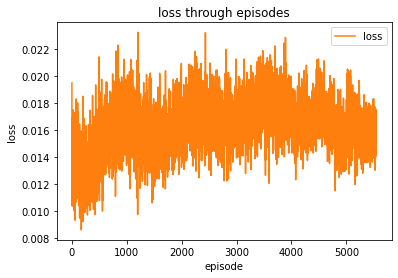

In [30]:
plot_value(total_loss, 'loss', filename, f"./{filename}_results", 'orange')

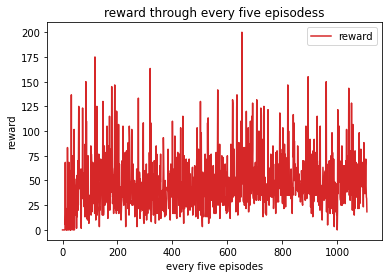

In [38]:
plot_value(eval_reward_record,'reward', filename, f"./{filename}_results", x = 'every five episodes')

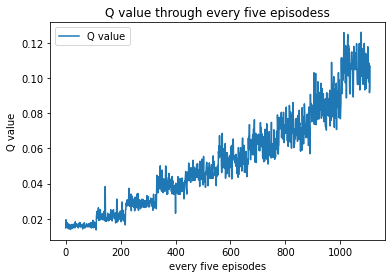

In [39]:
plot_value(eval_Q_value_record,'Q value', filename, f"./{filename}_results", 'blue', 'every five episodes')

## Playing

In [16]:
import gym

In [35]:
env_name = 'SpaceInvaders-v0'
seed = 42
lr = 0.00025
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
env = gym.make(env_name)
env.seed(seed)

[42, 742738649]

In [19]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [22]:
agent = Agent(action_dim, 4, lr, device)

In [23]:
agent.load(filename, directory=f"./{filename}_pytorch_models")

In [24]:
idx_to_action = {
    0:'NOP',
    1:'fight',
    2:'right',
    3:'left',
    4:'right and fight',
    5:'left and fight'
}

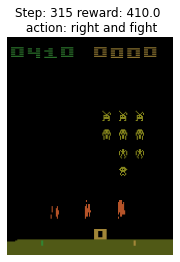

In [38]:
obs = env.reset()
state = deque([np.zeros((84, 84)) for i in range(4)],maxlen=4)
state.append(preprocess(obs))
for _ in range(3):
    obs, _, _, _ = env.step(0)
    state.append(preprocess(obs))
action = 0
done = False
t = 0
r = 0
while not done:
    t += 1
    
    action, _ = agent.select_action(np.array(state))
    #action = env.action_space.sample()
    for _ in range(4):
        obs, reward, done, _ = env.step(action)
        state.append(preprocess(obs))
        r += reward
        show_state(obs,t, f'reward: {r} \n action: {idx_to_action[action]}')
        if done: break
    

## Problem
* 不管 state 為何 model 都預測一樣的 
    - solution: reward 打錯字
* replaybuffer 有一堆 0 action (left)
    - solution: 調整 exploration
* reward 一直停在 0, 270, 285 原地射擊
    - solution: agent 落入 local maxima，調整超參數
* frame skipping 問題(實作錯誤) 
    - 錯誤: state(t1, t2, t3, t4) -> next state(t2, t3, t4, t5)
    - 正確: state(t1, t2, t3, t4) -> next state(t5, t6, t7, t8)
* OOM 問題:
    - solution: env playing時要把用完後的每個 timestep 的 state 和 stacked_frame 刪掉以減少 memory 負擔
* 不管甚麼 state, agent 都輸出一樣的 Q value
    - solution: 訓練次數太少，且落入 local maxima